## To discuss the clustering of deformation pattern

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from natsort import natsort
from sklearn.cluster import KMeans
import pandas as pd
from matplotlib.colors import ListedColormap

In [5]:
def make_particle_change_lists(change_lists_array, num_list=False):
    particel_num_lists_1d_array = np.asarray([np.hsplit(change_lists_array[num],[1])[0] 
                            for num in range(len(change_lists_array))],dtype=object)
        
    change_lists_1d_array = np.asarray([np.hsplit(change_lists_array[num],[1])[1] 
                            for num in range(len(change_lists_array))],dtype=object)
    
        ## remove  nan and inf value
    change_lists_1d_array_mod = np.asarray([np.nan_to_num(change_lists_1d_array[num],nan=0.0, posinf=0.0, neginf=0.0) 
                                        for num in range(len(change_lists_1d_array))],dtype=object)
    result_lists = []
    
    if num_list == False:
        for i in tqdm(np.unique(particel_num_lists_1d_array[0])):
            change_rate_lists = []
            for j in range(len(change_lists_1d_array)):
                change_list_1d_array = change_lists_1d_array_mod[j]
                change_rate = change_list_1d_array[np.where(particel_num_lists_1d_array[j]==i)[0]]
                if change_rate.size==0:
                    continue
                else:
                    change_rate_lists.extend(change_rate)
            result_lists.append(change_rate_lists)
    
    if num_list == True:
        num_list_and_particle_change_rate_lists = []
        for i in tqdm(np.unique(particel_num_lists_1d_array[0])):
            change_rate_lists = []
            for j in range(len(change_lists_1d_array)):
                change_list_1d_array = change_lists_1d_array_mod[j]
                change_rate = change_list_1d_array[np.where(particel_num_lists_1d_array[j]==i)[0]]
                if change_rate.size==0:
                    continue
                else:   
                    change_rate_lists.extend(change_rate)
            
            insert = np.zeros(len(change_lists_array))
            insert[:len(change_rate_lists)] = change_rate_lists
            change_rate_lists = insert
            change_rate_lists_2 = np.append(i, change_rate_lists)
            result_lists.append(change_rate_lists_2)

        
    return result_lists



def modify_change_rate_lists(particle_change_rate_lists):
    particle_change_rate_lists_mod = []
    
    for i in tqdm(range(len(particle_change_rate_lists))):
        particle_change_rate_list = particle_change_rate_lists[i]
        if np.max(particle_change_rate_list[0:25])>=25 or np.min(particle_change_rate_list[0:25])<=-25 or np.max(particle_change_rate_list)>=50 or np.min(particle_change_rate_list)<=-50:
            pass
        else:
            particle_change_rate_lists_mod.append(particle_change_rate_list)
            
    return particle_change_rate_lists_mod

In [6]:
def result_visualization_kmeans(nuclei_list, track_result_filtered, change_rate_result, kmeans_results):
    #set 3D storage
    result_map = np.zeros((nuclei_list[:,:,0].shape[0], nuclei_list[:,:,0].shape[1], len(change_rate_result)))
    
    #extract particle num satisfying check number
    frame_num_list=np.unique(track_result_filtered['frame'])
    
    target_change_rate_result = change_rate_result[0]
    target_particel_num_lists = np.concatenate(np.hsplit(target_change_rate_result,[1])[0])
    
    for frame_num in tqdm(frame_num_list):
        #extract information of the certain frame
        track_result_certain_frame=track_result_filtered[track_result_filtered["frame"]==frame_num]        
        #set target
        
        new_label=np.unique(nuclei_list[:,:, frame_num])[1:]
        target_nuclei=list(nuclei_list[:,:, frame_num].flatten())
        # target_change_rate_result = change_rate_result[0]
        # target_particel_num_lists = np.concatenate(np.hsplit(target_change_rate_result,[1])[0])
        
        #set zero map
        zero_map=np.zeros((nuclei_list[:,:,0].shape[0]*nuclei_list[:,:,0].shape[1]))    

        #set function
        replace_func = {new: k_label for new, k_label in zip(target_particel_num_lists, kmeans_results)} 

        #replace label values to anatomical values
        replace_result=np.asarray(list(map(replace_func.get, target_nuclei)))
        result_index=np.where(replace_result!=None)[0]

        #project the result to zero map
        zero_map[result_index]=replace_result[result_index]

        #save result
        result_map[:,:,frame_num]=zero_map.reshape((nuclei_list[:,:,0].shape[0], nuclei_list[:,:,0].shape[1]))
        
    return result_map

In [7]:
def kmeans_map_and_distribution(nuclei_true, lists_array, num_for_normalized_start_point, num_clusters, change_lists_array, track_result_filtered):
    num = num_for_normalized_start_point
    
    first_list = []
    for j in range(len(lists_array[0])):
        average_value = np.average([lists_array[k][j][1:2].astype('float') for k in range(num)])
        average_num = np.average([lists_array[k][j][0:1].astype('float') for k in range(num)])
        average = np.asarray([average_num, average_value])
        first_list.append(average)
    target_list_all = np.vstack((np.expand_dims(first_list, axis=0),lists_array[num:]))
    
    change_lists_mod = []
    for i in tqdm(range(len(target_list_all))):
        first_list = target_list_all[0]
        target_list = target_list_all[i]
        selected_list = first_list[np.where(first_list[:,:1]==np.intersect1d(first_list[:,:1], target_list[:,:1]))[0]]
        change_rate = ((target_list[:,1:2] - selected_list[:,1:2])/selected_list[:,1:2])*100
        change_list = np.stack((target_list[:,:1][:,0], change_rate[:,0]), axis=-1)
        change_lists_mod.append(change_list)
        
    df_array_mod = make_particle_change_lists(change_lists_mod, num_list=True)
    df_array_mod = np.nan_to_num(df_array_mod, nan=0.0, posinf=0.0, neginf=0.0)
    df_mod = pd.DataFrame(df_array_mod)
    
    num_clusters = num_clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    model = kmeans.fit(df_mod.iloc[:,1:])
    kmeans_result = model.predict(df_mod.iloc[:,1:])
    kmeans_map = result_visualization_kmeans(nuclei_true, track_result_filtered, change_lists_array, kmeans_result)
    
    colors = ["gray", "blue", "green", "purple", "orange", "pink", "aqua","red"]
    
    def sort_colorlist(c_order,colorlist):
        clist = ['a']*len(colorlist)
        for k in range(len(clist)):
            clist[c_order[k]]= colorlist[k]
        return clist

    interval = np.arange(-.5,8,1)
    order, _=np.histogram(kmeans_result, bins=num_clusters)
    c_order=np.argsort(order)[::-1]
    adj_colorlist=sort_colorlist(c_order,colors)
    cmap = ListedColormap(adj_colorlist, name="custom")
    cmap.set_bad("black")
    cm = cmap

    fig, ax = plt.subplots(1,3,figsize=(20,6))

    ax[0].pcolormesh(np.ma.array(kmeans_map[:,:,-1], mask=nuclei_true[:,:,-1]==0), cmap = cm)
    ax[0].axis('off')
    ax[0].set_title('clustered image', fontsize=14)
    ax[0].set_aspect('equal')
    ax[0].invert_yaxis()

    for i in range(len(kmeans.cluster_centers_)):
        ax[1].plot(kmeans.cluster_centers_[i],c=adj_colorlist[i],linewidth=3)
    ax[1].set_title('Centor', fontsize=14)
    ax[1].set_xlabel('Strain', fontsize=14)

    #
    n, bins, patches = ax[2].hist(kmeans_result, bins=interval, rwidth=0.6, density=True)
    for i in range(num_clusters):
        patches[i].set_facecolor(adj_colorlist[i])
    ax[2].set_title('population in image', fontsize=14)
    ax[2].set_xlabel('cluster number',fontsize=14)

    fig.tight_layout()
    # plt.show()

### HR-1

In [50]:
HR_list = np.load('./seg_results/HR-1_common.npz',allow_pickle=True)
HR_map = np.load('./seg_results/HR-1_map_common.npz') 

In [51]:
HR_list.files

['area',
 'ecc',
 'cir',
 'major',
 'minor',
 'aspect_axis',
 'vert',
 'hori',
 'aspect_bbox',
 'feret',
 'area_change',
 'ecc_change',
 'cir_change',
 'major_change',
 'minor_change',
 'aspect_axis_change',
 'vert_change',
 'hori_change',
 'aspect_bbox_change',
 'feret_change']

In [8]:
track_result_filtered = pd.read_pickle("./seg_results/HR-1_filtered.pkl")
nuclei_true = HR_map['nuclei']
lists_array = HR_list['ecc']
change_lists_array = HR_list['ecc_change']

In [9]:
change_lists_mod = []

num = 5
first_list = []

for j in range(len(lists_array[0])):
    average_value = np.average([lists_array[k][j][1:2].astype('float') for k in range(num)])
    average_num = np.average([lists_array[k][j][0:1].astype('float') for k in range(num)])
    average = np.asarray([average_num, average_value])
    first_list.append(average)

target_list_all = np.vstack((np.expand_dims(first_list, axis=0),lists_array[num:]))

for i in tqdm(range(len(target_list_all))):
    first_list = target_list_all[0]
    target_list = target_list_all[i]
    selected_list = first_list[np.where(first_list[:,:1]==np.intersect1d(first_list[:,:1], target_list[:,:1]))[0]]
    change_rate = ((target_list[:,1:2] - selected_list[:,1:2])/selected_list[:,1:2])*100
    change_list = np.stack((target_list[:,:1][:,0], change_rate[:,0]), axis=-1)
    change_lists_mod.append(change_list)

100%|█████████████████████████████████████████| 189/189 [01:32<00:00,  2.04it/s]


In [12]:
df_array_mod = make_particle_change_lists(change_lists_mod, num_list=True)
df_mod = pd.DataFrame(df_array_mod)
df_mod.iloc[:,1:]

100%|███████████████████████████████████████| 5272/5272 [00:55<00:00, 95.00it/s]


,1,2,3,4,5,6,7,8,9,10,...,180,181,182,183,184,185,186,187,188,189
0,0.0,0.270136,-2.665607,-0.471193,2.092192,2.545622,4.306319,0.217004,2.085615,1.571845,...,2.715370,0.832214,7.531174,6.229957,3.697805,5.786230,-0.533631,6.128221,4.926007,6.549687
1,0.0,2.513271,0.443267,0.782988,2.899686,0.161632,-0.559907,-0.181010,-1.350500,-0.173061,...,16.479995,15.304143,20.574094,16.090343,15.564422,16.641670,17.843975,18.445758,14.664637,17.587360
2,0.0,-3.683952,3.175309,0.972598,2.392911,-2.603992,-0.707671,0.184370,-2.851854,-1.309280,...,13.595081,13.859318,13.694302,12.951565,13.699824,11.965630,14.948985,13.942778,16.010212,12.459918
3,0.0,5.274309,17.314112,4.202022,7.022218,4.777177,3.055778,15.084485,-0.665418,-10.273478,...,66.832519,67.559189,58.405216,66.043394,66.485950,63.540766,64.266934,65.560127,60.315585,69.235347
4,0.0,-5.590656,5.182947,1.416691,8.209989,7.488977,6.522154,9.428374,-1.967288,11.382156,...,60.552089,57.625628,58.831311,59.042066,59.300376,59.392920,56.223860,56.861525,60.386928,55.958127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5267,0.0,12.666788,10.188784,-15.621989,5.837695,5.274042,-12.823608,-11.382912,17.336726,-8.071302,...,-22.108719,4.237910,-26.308762,-38.469846,-19.422079,-41.859746,-50.160702,-37.555552,-57.542137,-25.751094
5268,0.0,-3.728217,7.214895,-23.928261,2.953558,-5.431135,-10.372613,-2.963273,6.749230,1.417396,...,-13.759291,0.797649,-7.697386,1.100308,2.365012,-21.609750,5.014032,-5.862501,5.572495,13.811343
5269,0.0,2.194418,0.854993,0.512101,3.814840,3.461027,10.632381,4.468453,4.266220,7.367066,...,5.263742,7.381235,2.066926,-0.382361,4.650417,-1.281424,-4.937012,-2.036797,4.265152,4.258328
5270,0.0,6.207159,7.571708,11.845844,29.302323,-6.334391,22.820514,11.387376,10.010660,17.533785,...,104.706168,106.320019,102.188277,105.543267,106.682623,107.493565,105.117572,106.186441,115.881085,105.996805


In [17]:
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
model = kmeans.fit(df_mod.iloc[:,1:])
kmeans_result = model.predict(df_mod.iloc[:,1:])

In [19]:
HR_ecc_kmeans_map = result_visualization_kmeans(nuclei_true,track_result_filtered, change_lists_array, kmeans_result)

100%|█████████████████████████████████████████| 193/193 [13:30<00:00,  4.20s/it]


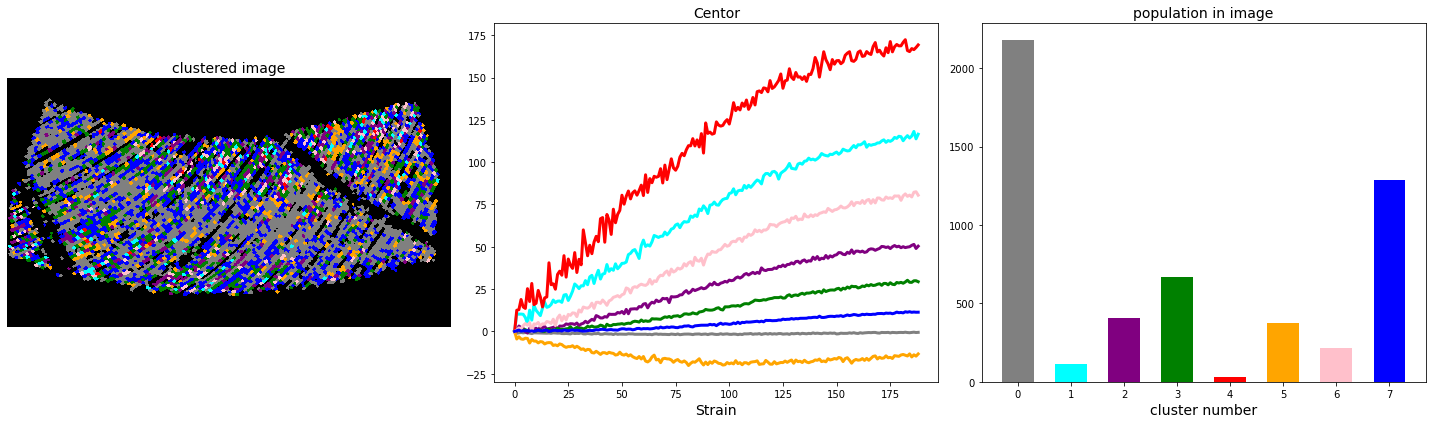

In [20]:
from matplotlib.colors import ListedColormap

colors = ["gray", "blue", "green", "purple", "orange", "pink", "aqua","red"]
def sort_colorlist(c_order,colorlist):
    clist = ['a']*len(colorlist)
    for k in range(len(clist)):
        clist[c_order[k]]= colorlist[k]
    return clist

interval = np.arange(-.5,8,1)
order, _=np.histogram(kmeans_result, bins=num_clusters)
c_order=np.argsort(order)[::-1]
adj_colorlist=sort_colorlist(c_order,colors)

cmap = ListedColormap(adj_colorlist, name="custom")
cmap.set_bad("black")
cm= cmap

fig, ax = plt.subplots(1,3,figsize=(20,6))

ax[0].pcolormesh(np.ma.array(HR_ecc_kmeans_map[:,:,-1], mask=nuclei_true[:,:,-1]==0), cmap = cm)
ax[0].axis('off')
ax[0].set_title('clustered image', fontsize=14)
ax[0].set_aspect('equal')
ax[0].invert_yaxis()

for i in range(len(kmeans.cluster_centers_)):
    ax[1].plot(kmeans.cluster_centers_[i],c=adj_colorlist[i],linewidth=3)
ax[1].set_title('Centor', fontsize=14)
ax[1].set_xlabel('Strain', fontsize=14)

#
n, bins, patches = ax[2].hist(kmeans_result, bins=interval, rwidth=0.6)
for i in range(num_clusters):
    patches[i].set_facecolor(adj_colorlist[i])
ax[2].set_title('population in image', fontsize=14)
ax[2].set_xlabel('cluster number',fontsize=14)

fig.tight_layout()
# plt.show()

100%|█████████████████████████████████████████| 193/193 [09:19<00:00,  2.90s/it]


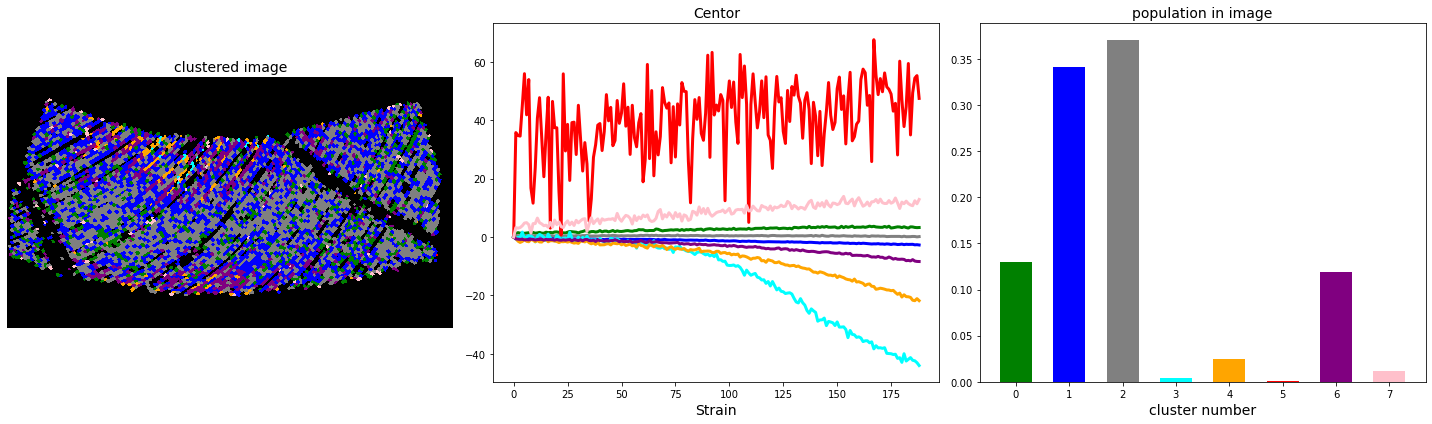

In [56]:
track_result_filtered = pd.read_pickle("./seg_results/HR-1_filtered.pkl")
nuclei_true = HR_map['nuclei']
lists_array = HR_list['area']
change_lists_array = HR_list['area_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 5, 8, change_lists_array, track_result_filtered)

100%|█████████████████████████████████████████| 193/193 [08:57<00:00,  2.78s/it]


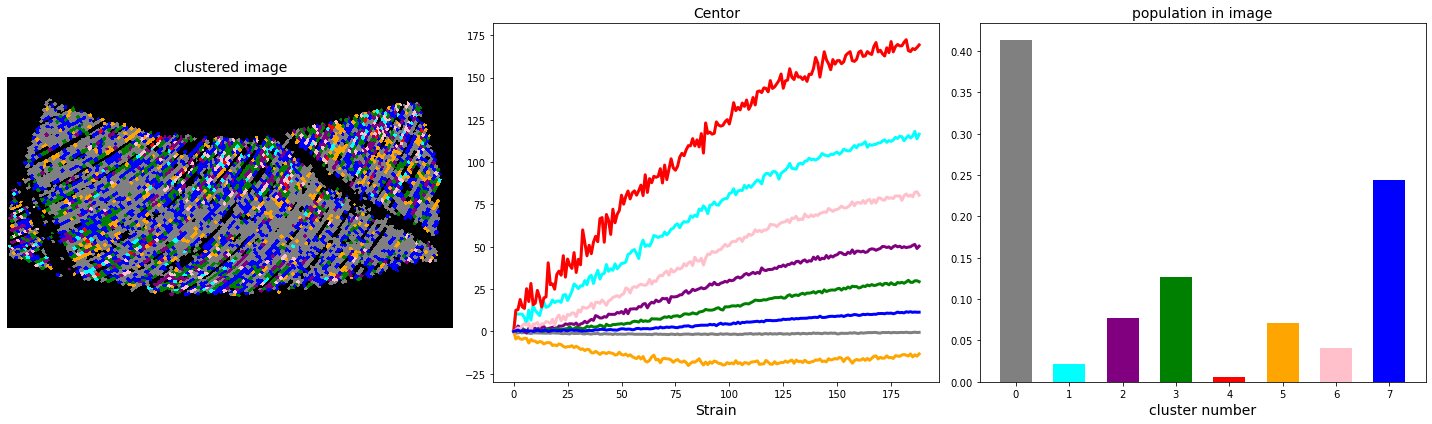

In [52]:
track_result_filtered = pd.read_pickle("./seg_results/HR-1_filtered.pkl")
nuclei_true = HR_map['nuclei']
lists_array = HR_list['ecc']
change_lists_array = HR_list['ecc_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 5, 8, change_lists_array, track_result_filtered)

100%|█████████████████████████████████████████| 193/193 [09:13<00:00,  2.87s/it]


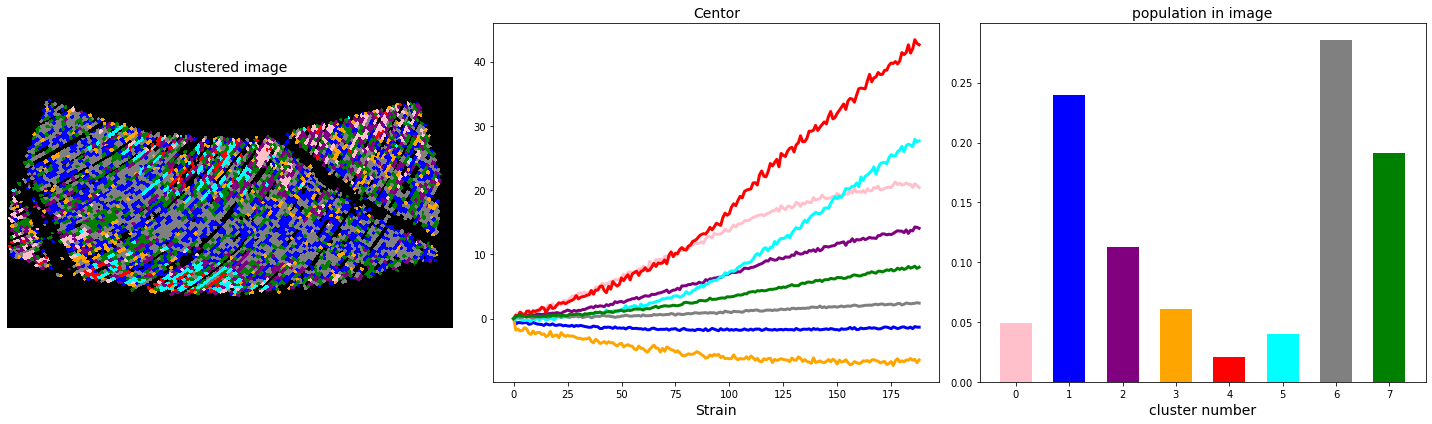

In [53]:
track_result_filtered = pd.read_pickle("./seg_results/HR-1_filtered.pkl")
nuclei_true = HR_map['nuclei']
lists_array = HR_list['aspect_axis']
change_lists_array = HR_list['aspect_axis_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 5, 8, change_lists_array, track_result_filtered)

100%|█████████████████████████████████████████| 193/193 [09:28<00:00,  2.95s/it]


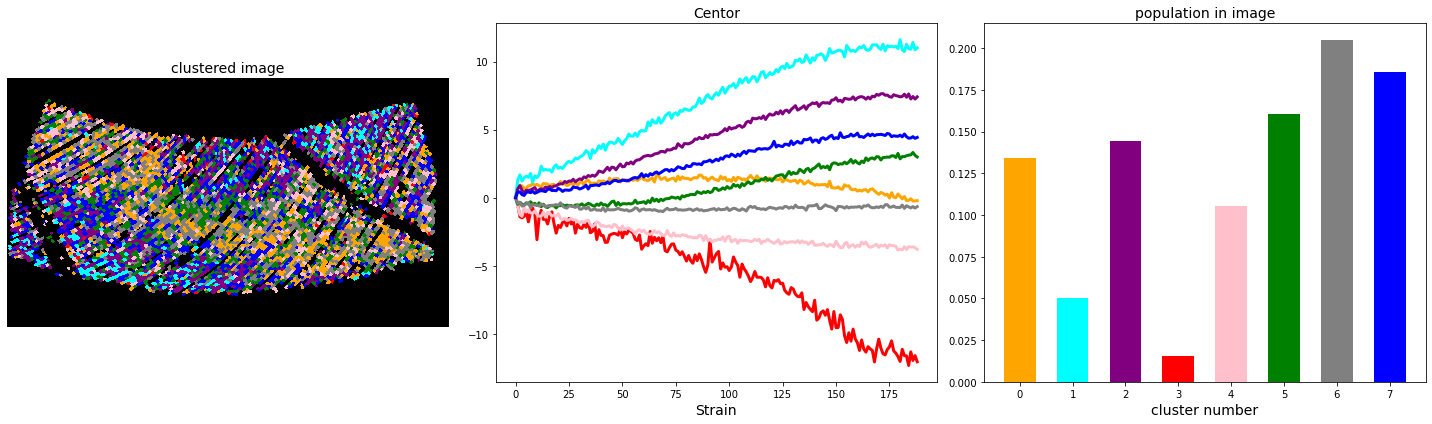

In [54]:
track_result_filtered = pd.read_pickle("./seg_results/HR-1_filtered.pkl")
nuclei_true = HR_map['nuclei']
lists_array = HR_list['feret']
change_lists_array = HR_list['feret_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 5, 8, change_lists_array, track_result_filtered)

100%|█████████████████████████████████████████| 193/193 [09:23<00:00,  2.92s/it]


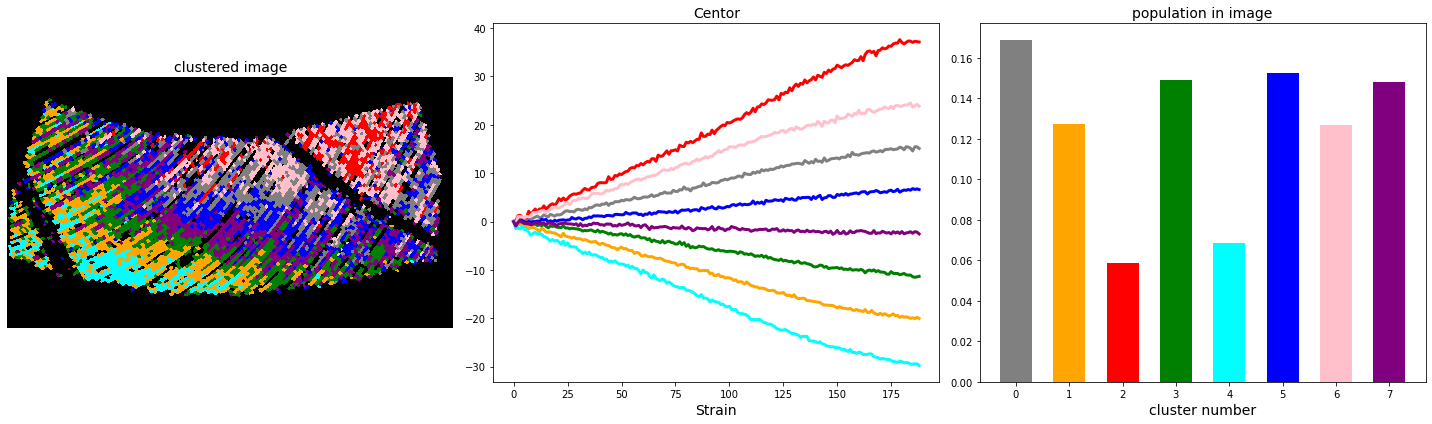

In [55]:
track_result_filtered = pd.read_pickle("./seg_results/HR-1_filtered.pkl")
nuclei_true = HR_map['nuclei']
lists_array = HR_list['aspect_bbox']
change_lists_array = HR_list['aspect_bbox_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 5, 8, change_lists_array, track_result_filtered)

### r-H-5

In [57]:
HR_list = np.load('./seg_results/r-H-5_common.npz',allow_pickle=True)
HR_map = np.load('./seg_results/r-H-5_map_common.npz') 

In [58]:
HR_list.files

['area',
 'ecc',
 'cir',
 'major',
 'minor',
 'aspect_axis',
 'vert',
 'hori',
 'aspect_bbox',
 'feret',
 'area_change',
 'ecc_change',
 'cir_change',
 'major_change',
 'minor_change',
 'aspect_axis_change',
 'vert_change',
 'hori_change',
 'aspect_bbox_change',
 'feret_change']

100%|█████████████████████████████████████████| 192/192 [07:17<00:00,  2.28s/it]


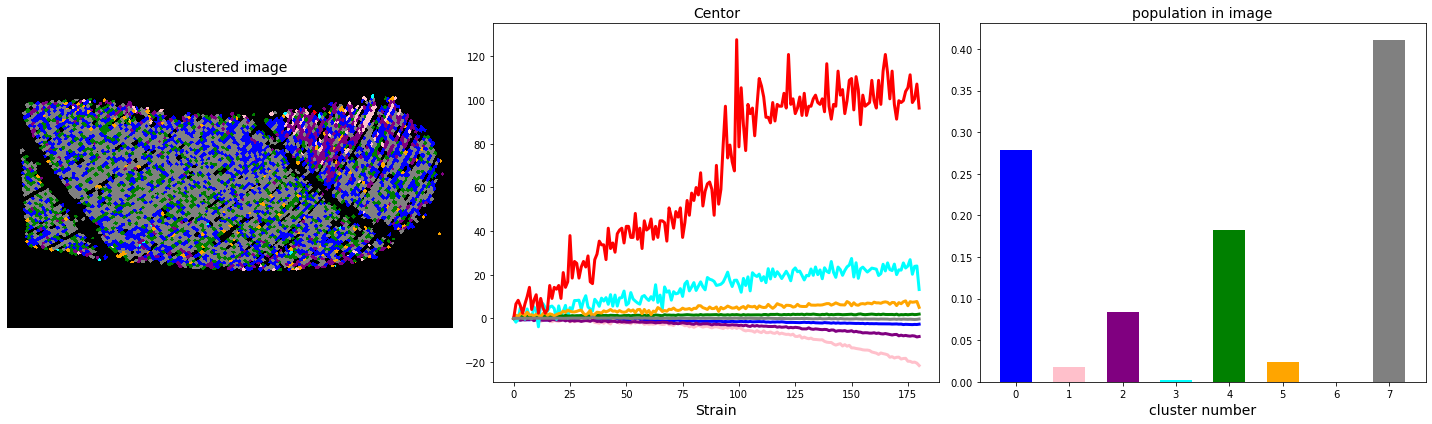

In [59]:
track_result_filtered = pd.read_pickle("./seg_results/r-H-5_filtered.pkl")
nuclei_true = HR_map['nuclei']
lists_array = HR_list['area']
change_lists_array = HR_list['area_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 12, 8, change_lists_array, track_result_filtered)

100%|█████████████████████████████████████████| 192/192 [01:25<00:00,  2.26it/s]


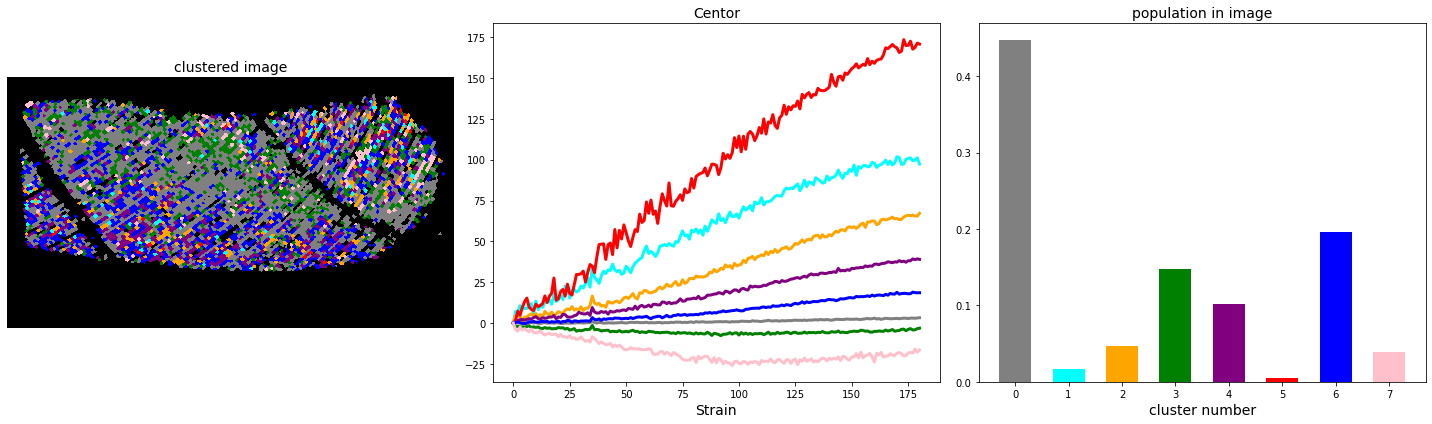

In [40]:
track_result_filtered = pd.read_pickle("./seg_results/r-H-5_filtered.pkl")
nuclei_true = HR_map['nuclei']
lists_array = HR_list['ecc']
change_lists_array = HR_list['ecc_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 12, 8, change_lists_array, track_result_filtered)

100%|█████████████████████████████████████████| 192/192 [01:28<00:00,  2.16it/s]


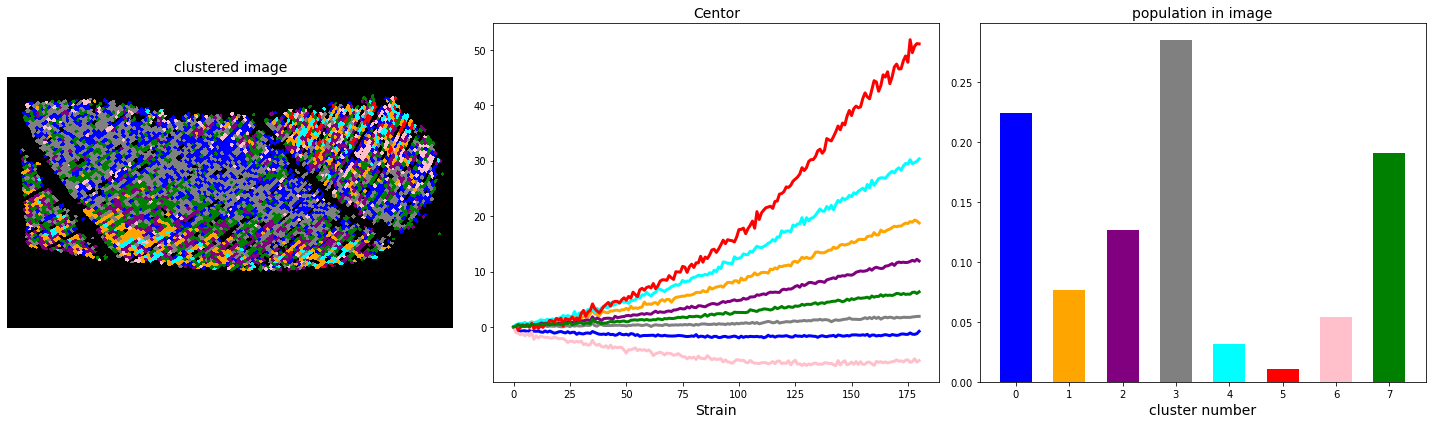

In [45]:
track_result_filtered = pd.read_pickle("./seg_results/r-H-5_filtered.pkl")
nuclei_true = HR_map['nuclei']
lists_array = HR_list['aspect_axis']
change_lists_array = HR_list['aspect_axis_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 12, 8, change_lists_array, track_result_filtered)

100%|█████████████████████████████████████████| 192/192 [04:27<00:00,  1.40s/it]


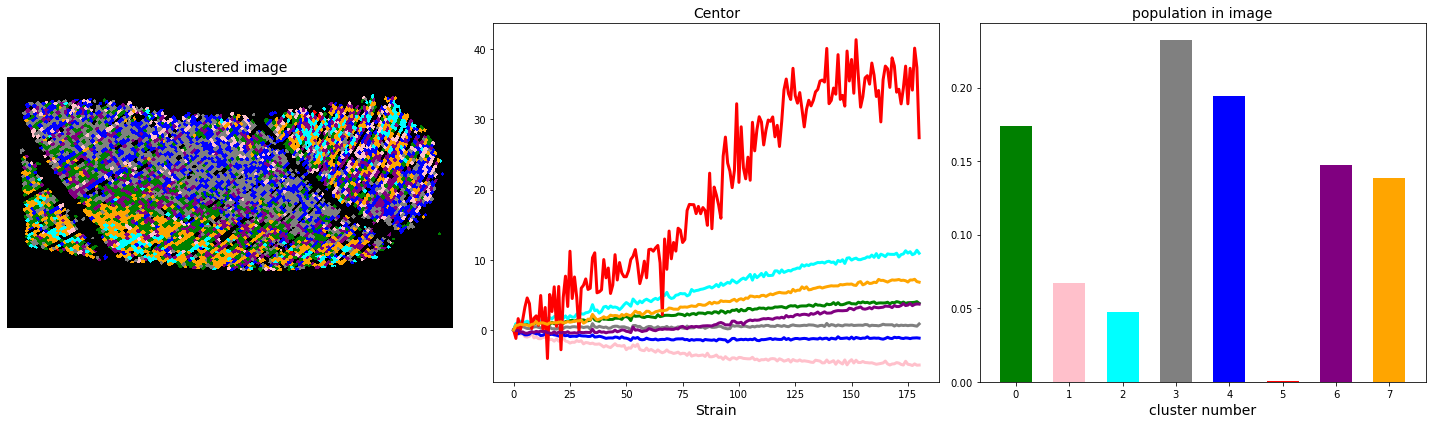

In [48]:
track_result_filtered = pd.read_pickle("./seg_results/r-H-5_filtered.pkl")
nuclei_true = HR_map['nuclei']
lists_array = HR_list['feret']
change_lists_array = HR_list['feret_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 12, 8, change_lists_array, track_result_filtered)

100%|█████████████████████████████████████████| 192/192 [01:27<00:00,  2.20it/s]


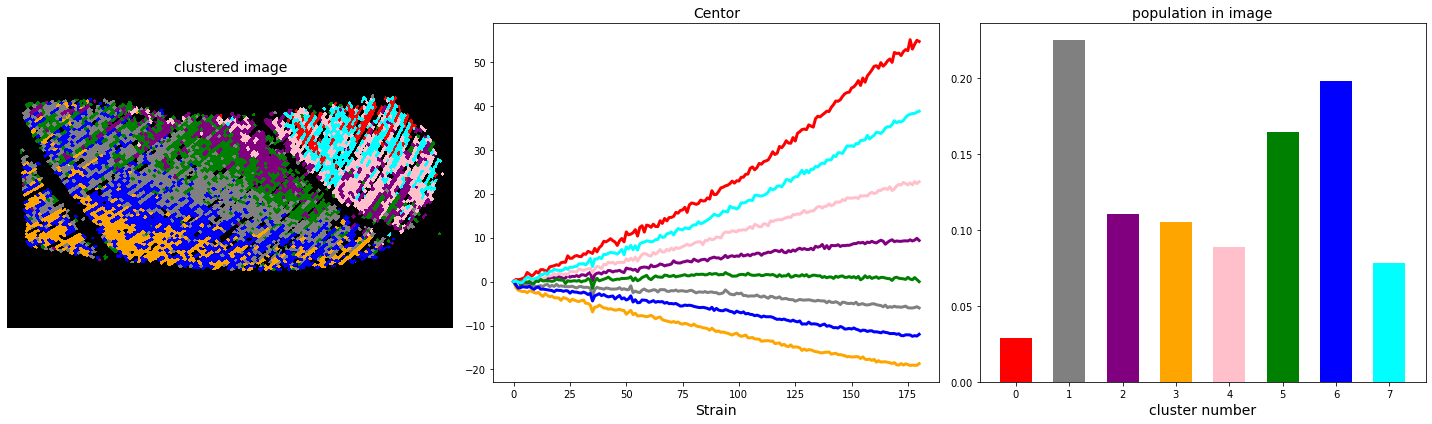

In [47]:
track_result_filtered = pd.read_pickle("./seg_results/r-H-5_filtered.pkl")
nuclei_true = HR_map['nuclei']
lists_array = HR_list['aspect_bbox']
change_lists_array = HR_list['aspect_bbox_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 12, 8, change_lists_array, track_result_filtered)

### HF-4

In [8]:
HF_list = np.load('./seg_results/HF-4_common.npz',allow_pickle=True)
HF_map = np.load('./seg_results/HF-4_map_common.npz') 

In [9]:
HF_list.files

['area',
 'ecc',
 'cir',
 'major',
 'minor',
 'aspect_axis',
 'vert',
 'hori',
 'aspect_bbox',
 'feret',
 'area_change',
 'ecc_change',
 'cir_change',
 'major_change',
 'minor_change',
 'aspect_axis_change',
 'vert_change',
 'hori_change',
 'aspect_bbox_change',
 'feret_change']

100%|███████████████████████████████████████████| 88/88 [00:42<00:00,  2.06it/s]


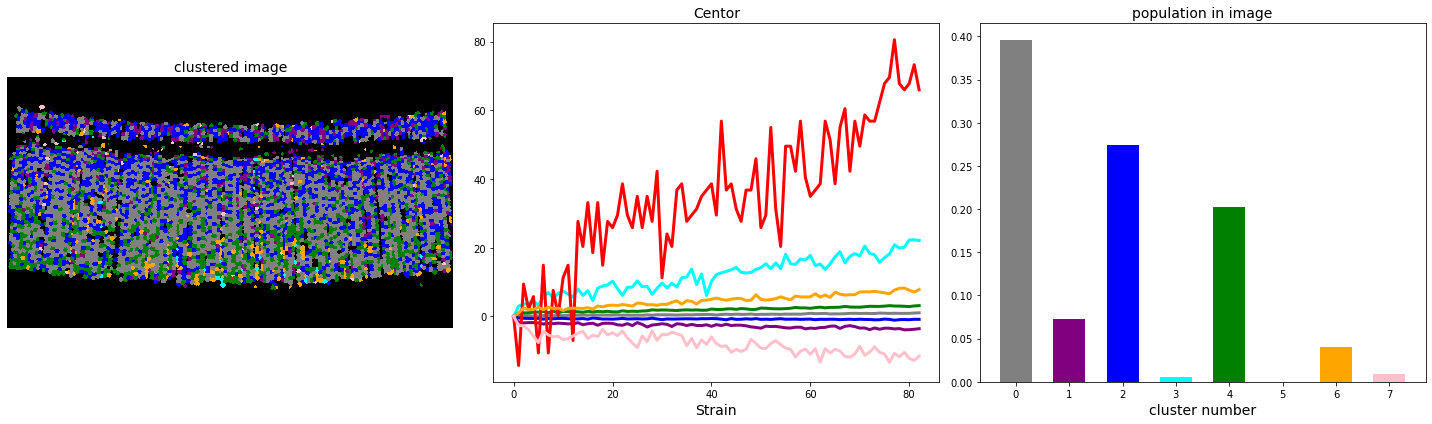

In [11]:
track_result_filtered = pd.read_pickle("./seg_results/HF-4_filtered.pkl")
nuclei_true = HF_map['nuclei']
lists_array = HF_list['area']
change_lists_array = HF_list['area_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 6, 8, change_lists_array, track_result_filtered)

100%|███████████████████████████████████████████| 88/88 [00:43<00:00,  2.03it/s]


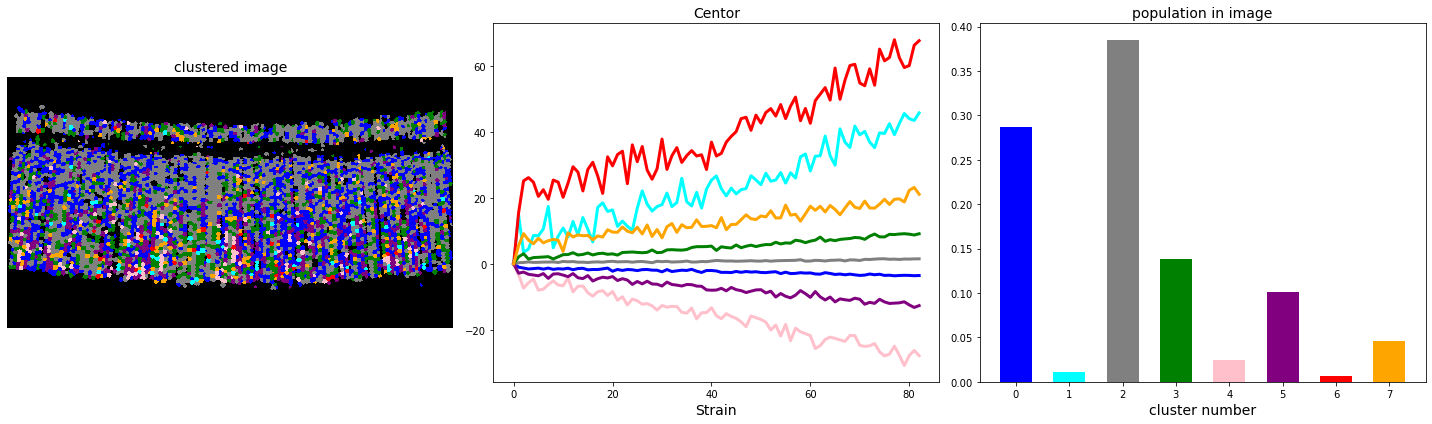

In [12]:
track_result_filtered = pd.read_pickle("./seg_results/HF-4_filtered.pkl")
nuclei_true = HF_map['nuclei']
lists_array = HF_list['ecc']
change_lists_array = HF_list['ecc_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 6, 8, change_lists_array, track_result_filtered)

100%|███████████████████████████████████████████| 88/88 [00:46<00:00,  1.90it/s]


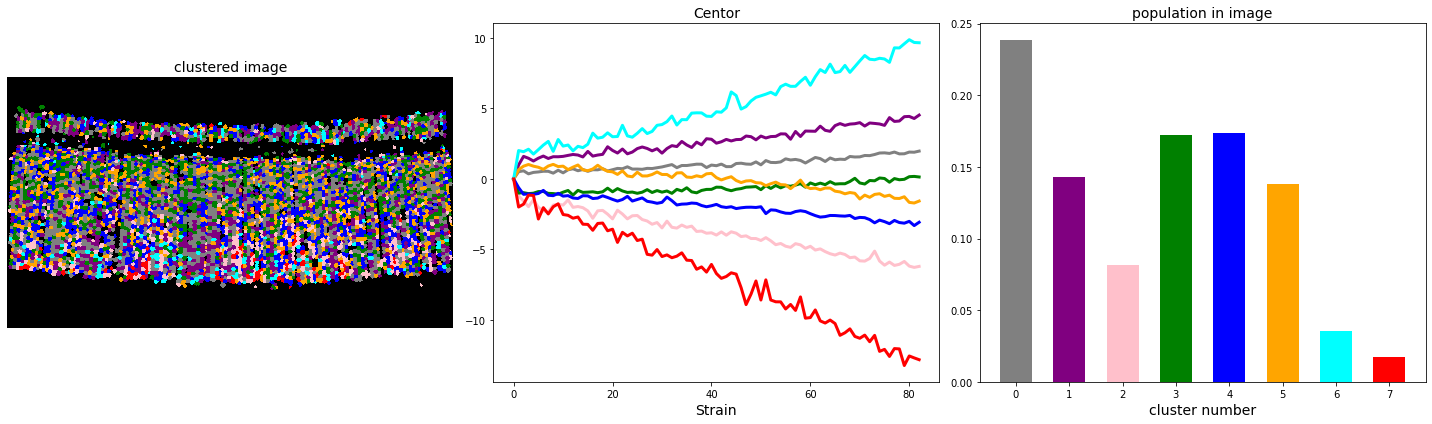

In [13]:
track_result_filtered = pd.read_pickle("./seg_results/HF-4_filtered.pkl")
nuclei_true = HF_map['nuclei']
lists_array = HF_list['aspect_axis']
change_lists_array = HF_list['aspect_axis_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 6, 8, change_lists_array, track_result_filtered)

100%|███████████████████████████████████████████| 88/88 [00:42<00:00,  2.05it/s]


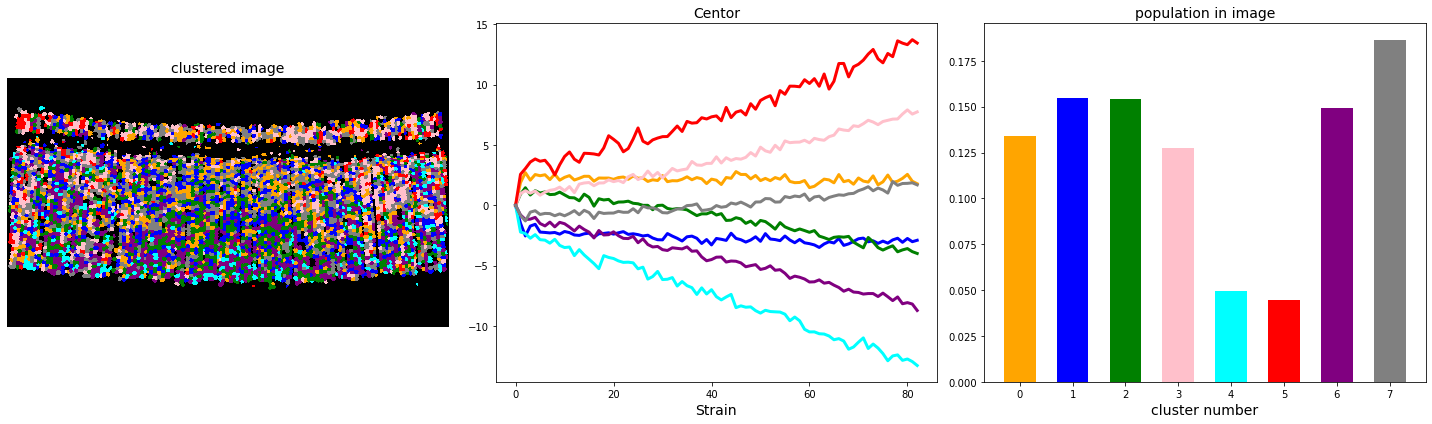

In [14]:
track_result_filtered = pd.read_pickle("./seg_results/HF-4_filtered.pkl")
nuclei_true = HF_map['nuclei']
lists_array = HF_list['aspect_bbox']
change_lists_array = HF_list['aspect_bbox']

kmeans_map_and_distribution(nuclei_true, lists_array, 6, 8, change_lists_array, track_result_filtered)

100%|███████████████████████████████████████████| 88/88 [00:42<00:00,  2.09it/s]


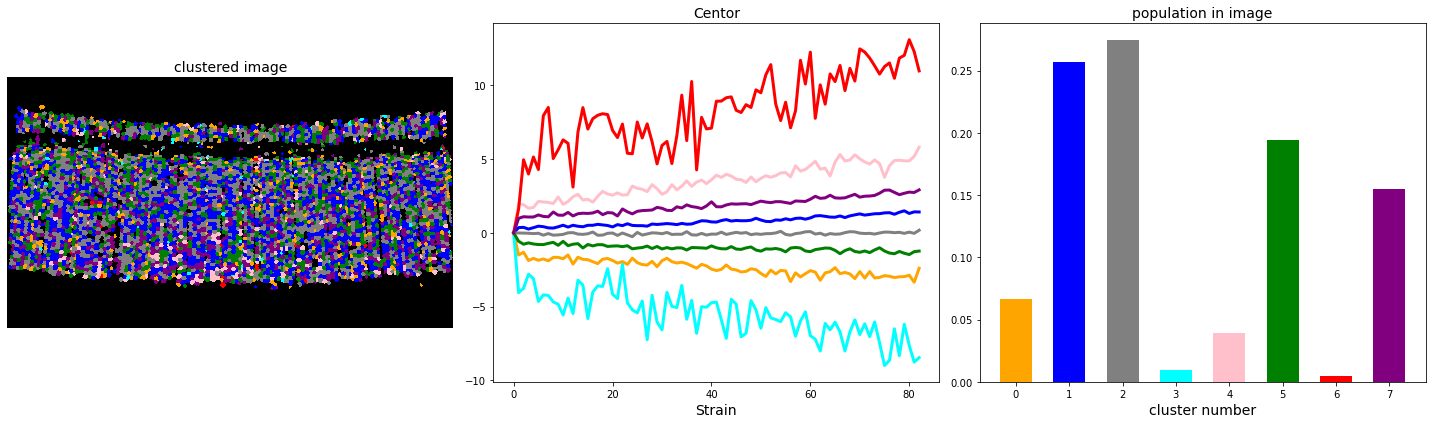

In [15]:
track_result_filtered = pd.read_pickle("./seg_results/HF-4_filtered.pkl")
nuclei_true = HF_map['nuclei']
lists_array = HF_list['feret']
change_lists_array = HF_list['feret_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 6, 8, change_lists_array, track_result_filtered)

### q-H-2

In [3]:
# the first frame was not used
HQ_list = np.load('./seg_results/q-H-2_common.npz',allow_pickle=True)
HQ_map = np.load('./seg_results/q-H-2_map_common.npz') 

100%|███████████████████████████████████████████| 45/45 [00:22<00:00,  2.00it/s]


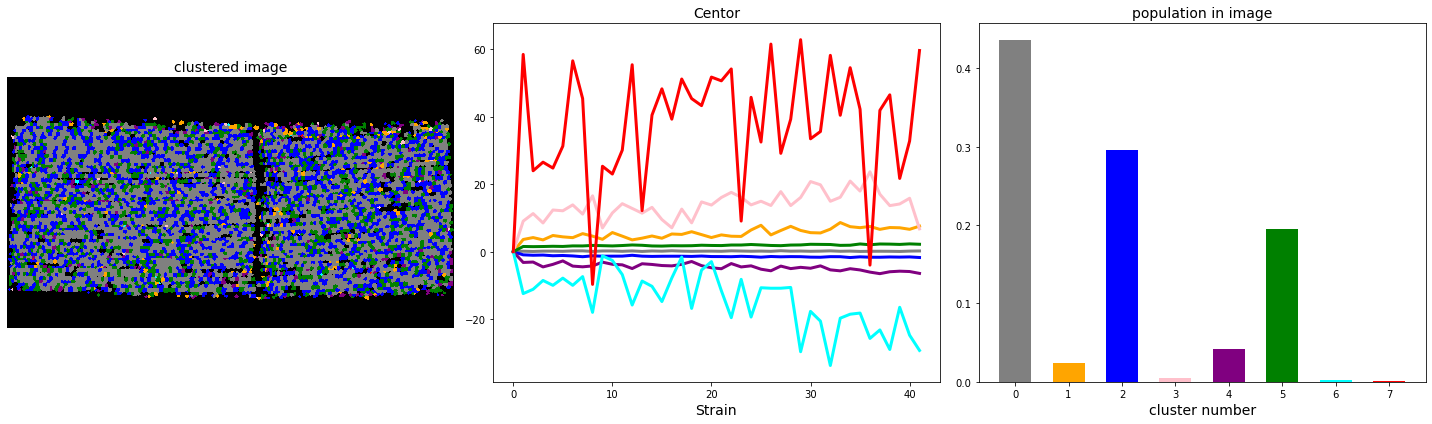

In [8]:
track_result_filtered = pd.read_pickle("./seg_results/q-H-2_filtered.pkl")
nuclei_true = HQ_map['nuclei']
lists_array = HQ_list['area']
change_lists_array = HQ_list['area_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 4, 8, change_lists_array, track_result_filtered)

100%|███████████████████████████████████████████| 45/45 [00:22<00:00,  2.02it/s]


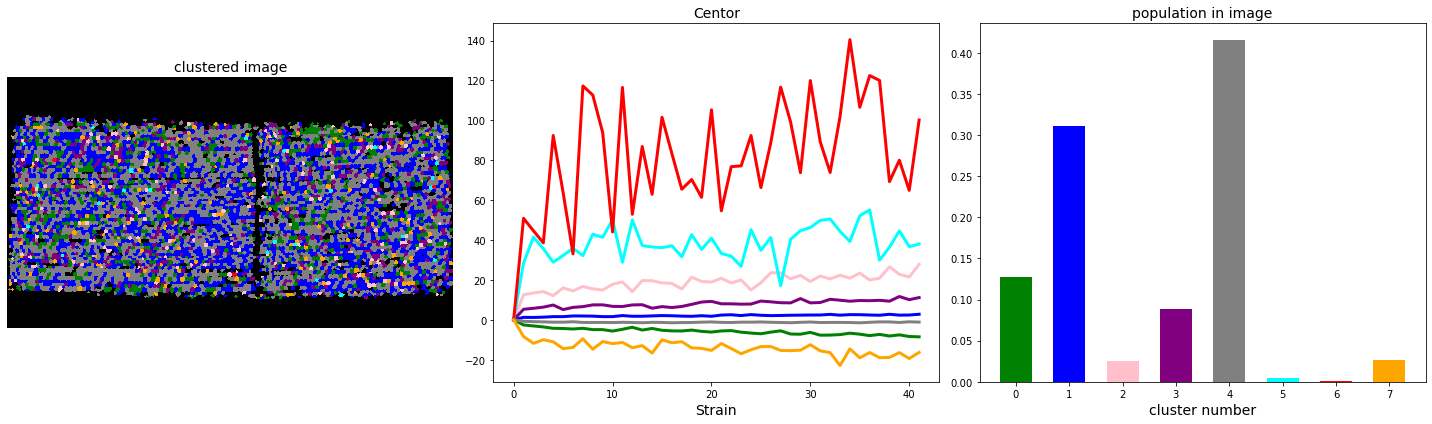

In [9]:
track_result_filtered = pd.read_pickle("./seg_results/q-H-2_filtered.pkl")
nuclei_true = HQ_map['nuclei']
lists_array = HQ_list['ecc']
change_lists_array = HQ_list['ecc_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 4, 8, change_lists_array, track_result_filtered)

100%|███████████████████████████████████████████| 45/45 [00:22<00:00,  2.03it/s]


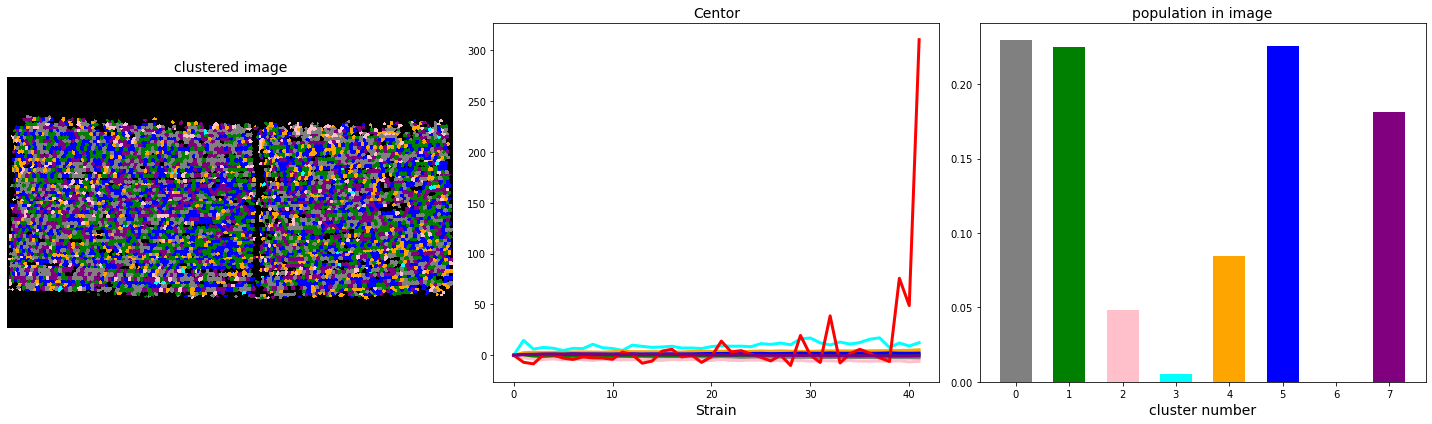

In [10]:
track_result_filtered = pd.read_pickle("./seg_results/q-H-2_filtered.pkl")
nuclei_true = HQ_map['nuclei']
lists_array = HQ_list['aspect_axis']
change_lists_array = HQ_list['aspect_axis_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 4, 8, change_lists_array, track_result_filtered)

100%|███████████████████████████████████████████| 45/45 [00:22<00:00,  2.01it/s]


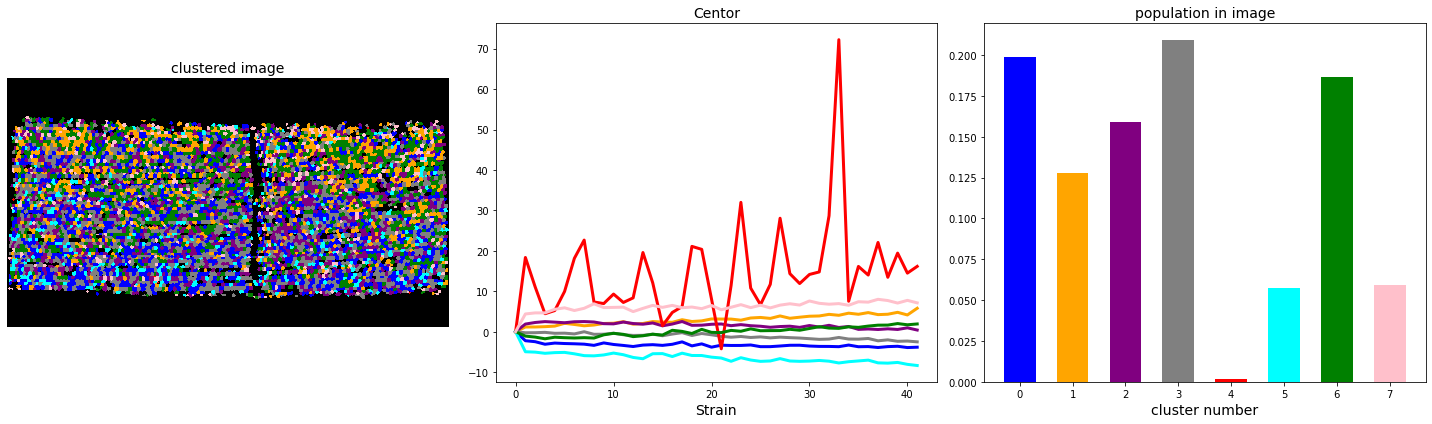

In [11]:
track_result_filtered = pd.read_pickle("./seg_results/q-H-2_filtered.pkl")
nuclei_true = HQ_map['nuclei']
lists_array = HQ_list['aspect_bbox']
change_lists_array = HQ_list['aspect_bbox_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 4, 8, change_lists_array, track_result_filtered)

100%|███████████████████████████████████████████| 45/45 [00:22<00:00,  2.01it/s]


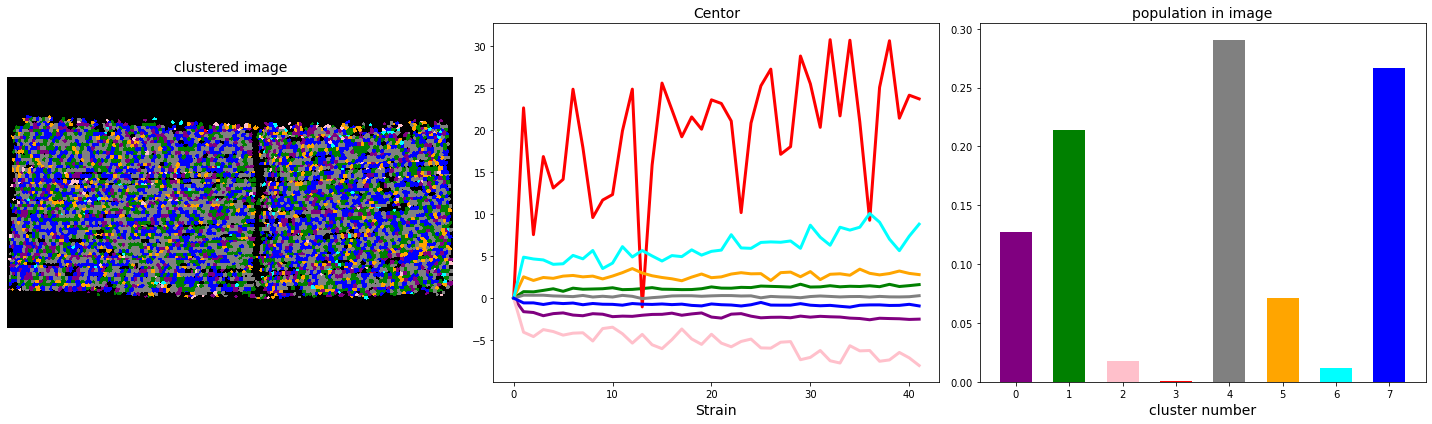

In [12]:
track_result_filtered = pd.read_pickle("./seg_results/q-H-2_filtered.pkl")
nuclei_true = HQ_map['nuclei']
lists_array = HQ_list['feret']
change_lists_array = HQ_list['feret_change']

kmeans_map_and_distribution(nuclei_true, lists_array, 4, 8, change_lists_array, track_result_filtered)